In [3]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def make_tfrecords(images, labels, type):

    num_examples = labels.shape[0]

    if images.shape[0] != num_examples:
        raise ValueError("Images size %d does not match label size %d." %
                         (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    directory = "."

    filename = os.path.join(directory, type + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(len(labels)):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'label': _int64_feature(int(labels[index])),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def extract_image_label(folder, type):
    print("extracting from " + str(folder))
    csv_file = pd.read_csv("/Volumes/DANIEL/Challenge-2/" + type + "/%d/interpolated.csv" % int(folder),
                           usecols=['filename', 'angle', 'frame_id'])
    csv_file = csv_file[csv_file['frame_id'] == "center_camera"]

    dat_dir = "/Volumes/DANIEL/Challenge-2/" + type + "/%d/center/" % int(folder)

    images_list = [dat_dir + file for file in os.listdir(dat_dir) if not file.startswith("._")]
    images_name_list = [file for file in os.listdir(dat_dir) if not file.startswith("._")]
    

    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:

        tmp_image_lst = []
        tmp_label_lst = []
        tmp_img_name_lst = []

        for image_name in images_name_list:

            image = cv2.imread(dat_dir + "/" + image_name)
            image = cv2.resize(image, (80, 60))
            
            # store original image
            tmp_image_lst.append(image)  
            angle = csv_file['angle'][csv_file['filename'] == "center/" + image_name]
            tmp_label_lst.append(float(angle))
            tmp_img_name_lst.append(image_name)
            
            # store contract image
            contrast_image = image.copy()
            contrast_image = adjust_gamma(contrast_image, gamma=2)
            tmp_image_lst.append(contrast_image)
            tmp_label_lst.append(float(angle))
            tmp_img_name_lst.append("contrast_" + image_name)            
            
            # store flipped image
            flipped_image = image.copy()
            flipped_image = cv2.flip(flipped_image, 1)
            tmp_image_lst.append(flipped_image)
            tmp_label_lst.append(float(angle) * -1)            
            tmp_img_name_lst.append("flipped_" + image_name)
                
            # store flipped contract image
            flipped_contrast_image = flipped_image.copy()
            flipped_contrast_image = adjust_gamma(flipped_contrast_image, gamma=2)
            tmp_image_lst.append(flipped_contrast_image)
            tmp_label_lst.append(float(angle) * -1)
            tmp_img_name_lst.append("flipped_contrast_" + image_name)   
            
    images = np.array(tmp_image_lst)
    labels = np.array(tmp_label_lst)
    img_names = np.array(tmp_img_name_lst)
    return images, labels, img_names


In [90]:
imgs, labels, img_names = extract_image_label(1, "Sample")

extracting from 1


In [57]:
import pickle

In [59]:
img_label = {'images': imgs, 'labels': img_names}

In [60]:
pickle.dump( img_label, open( "sample.pkl", "wb" ) )

In [91]:
labels[0]

0.024434609338599998

In [97]:
img_names[3]

'flipped_contrast_1477429535973084853.png'

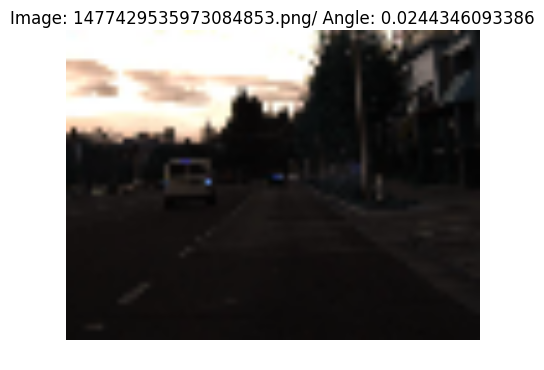

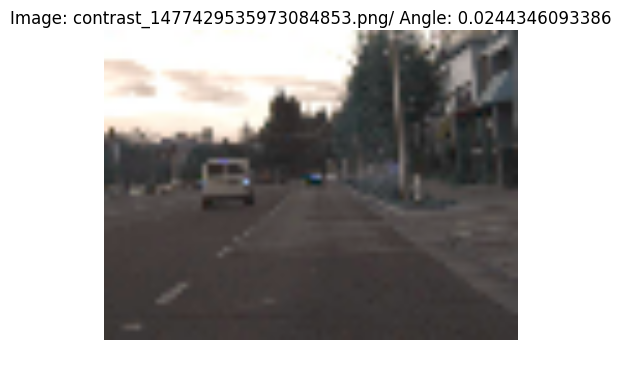

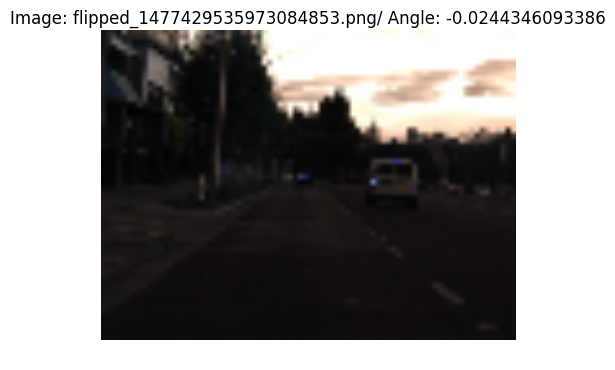

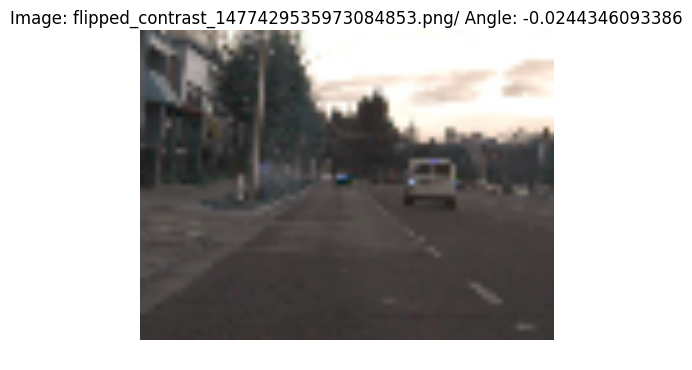

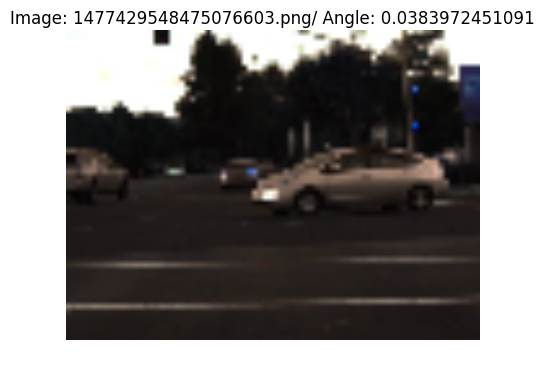

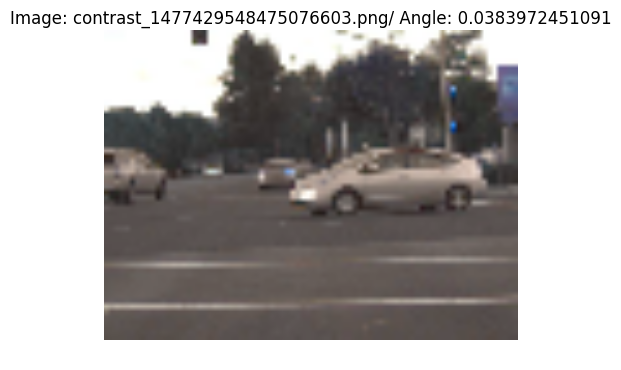

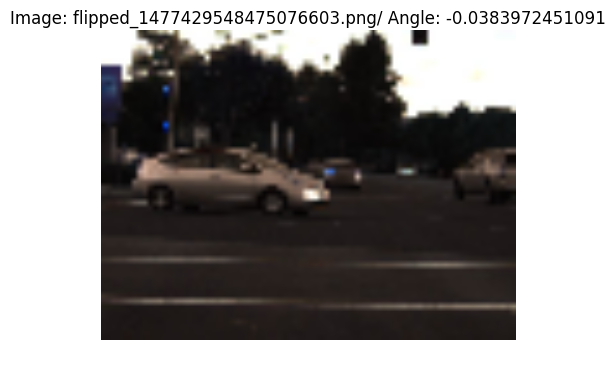

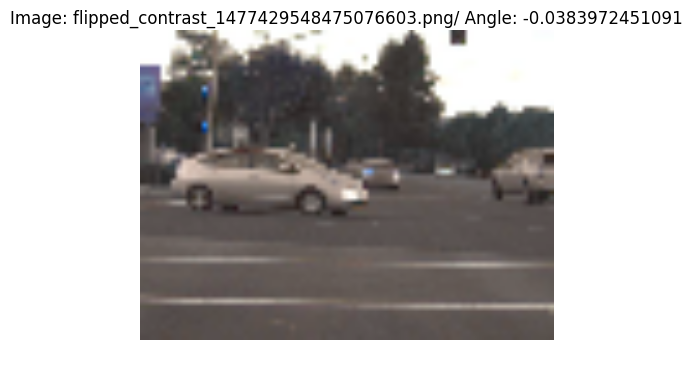

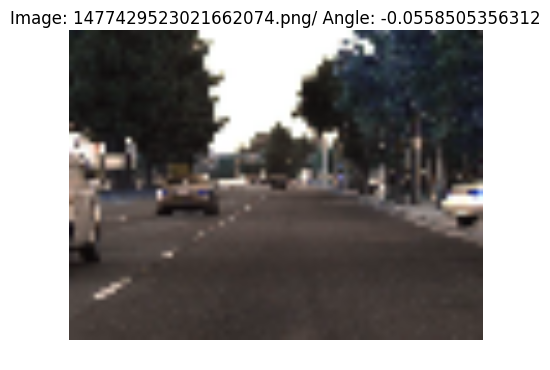

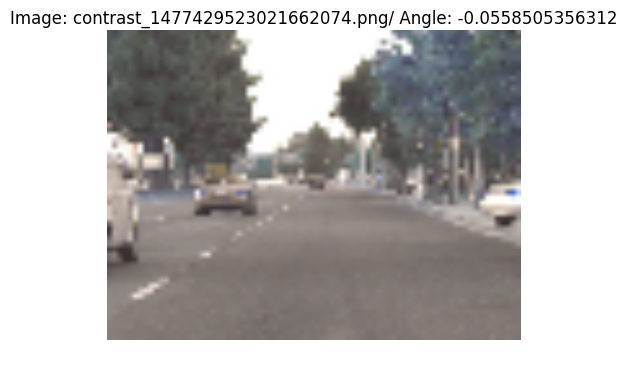

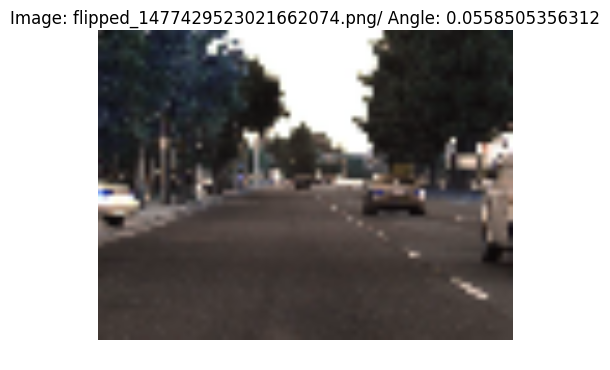

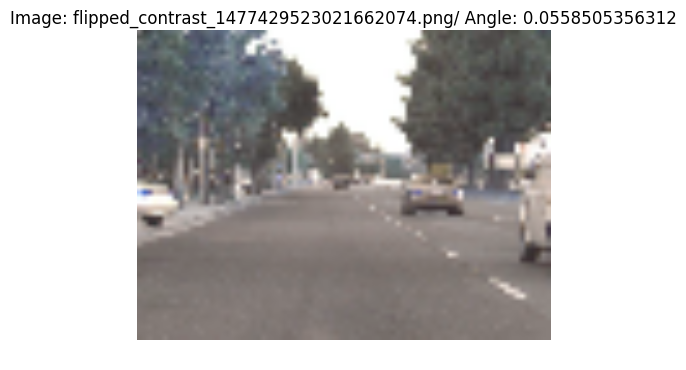

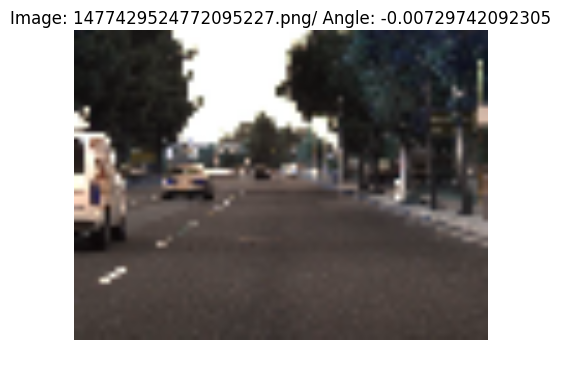

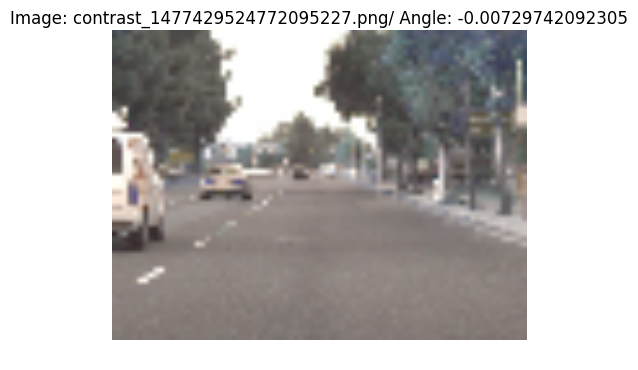

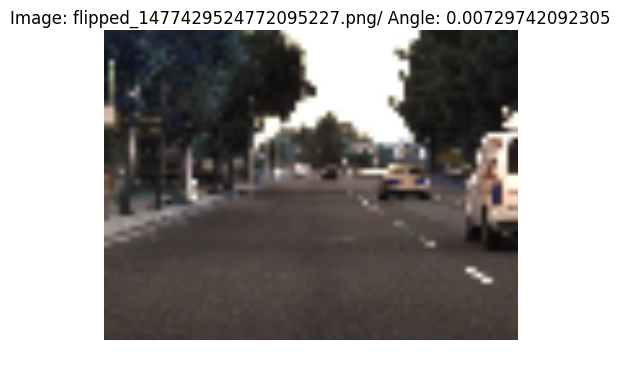

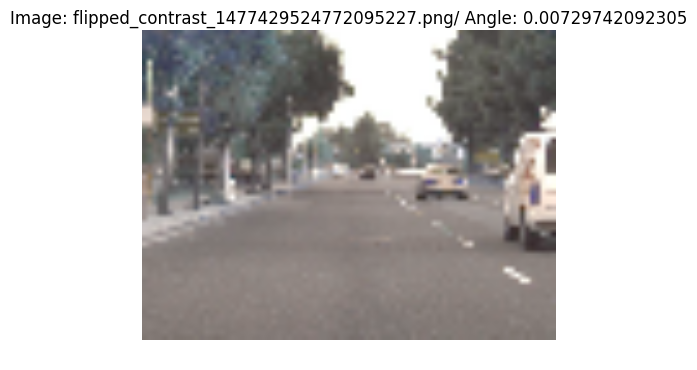

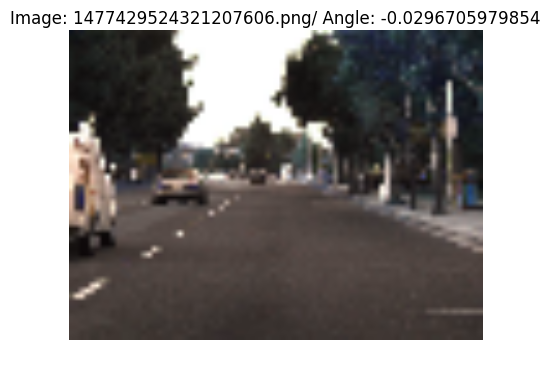

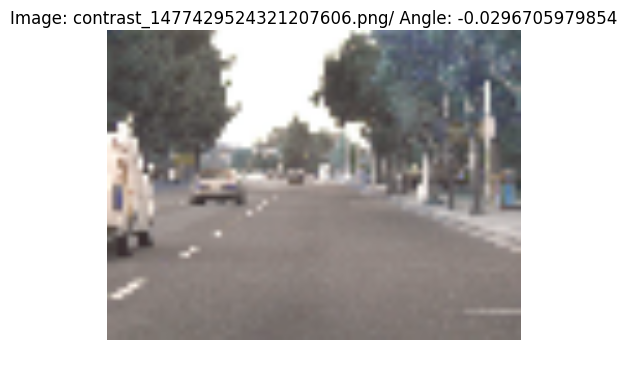

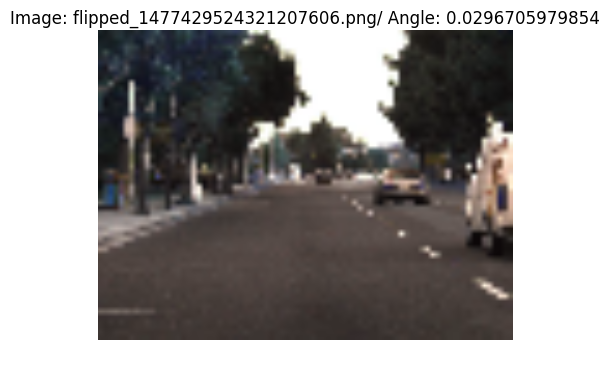

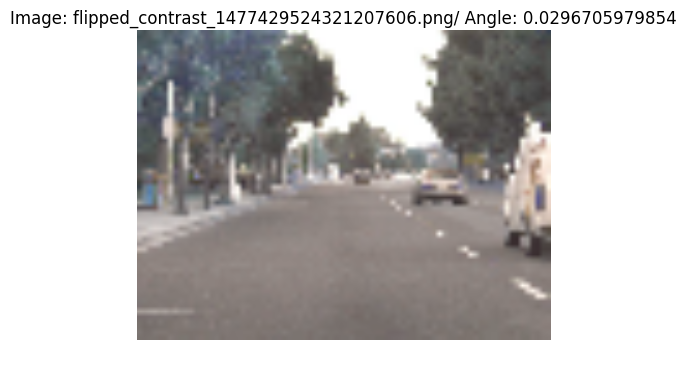

In [105]:
# sanity check
for i in range(20):
    plt.imshow(imgs[i])
    plt.title("Image: " + img_names[i] + "/ Angle: " + str(labels[i]))
    plt.axis('off')
    plt.show()

In [18]:
type = 'Train'
folders = [file for file in os.listdir("/Volumes/DANIEL/Challenge-2/" + type) if not file.startswith("._")]

In [38]:
def extract_csvfiles(folder):
   
    print("extracting from " + str(folder))
    csv_file = pd.read_csv("/Volumes/DANIEL/Challenge-2/Train/%s/interpolated.csv" % int(folder),
                           usecols=['filename', 'angle', 'frame_id'])
    csv_file = csv_file[csv_file['frame_id'] == "center_camera"]

    return csv_file


In [39]:
tmps = [extract_csvfiles(folder) for folder in folders]
aggregated_csv = pd.concat(tmps)

extracting from 10
extracting from 14
extracting from 15
extracting from 21
extracting from 9
extracting from 8
extracting from 18
extracting from 16
extracting from 12
extracting from 11
extracting from 13
extracting from 5
extracting from 20
extracting from 3
extracting from 4
extracting from 1
extracting from 6
extracting from 17
extracting from 19
extracting from 2


In [42]:
aggregated_csv.to_csv("total_center_angle.csv")

In [43]:
aggregated_csv.describe()

,angle
count,72176.000000
mean,-0.002339
std,0.037681
min,-0.359538
25%,-0.017453
50%,-0.001745
75%,0.011512
max,0.277507


In [49]:
type = 'Train'

folders = [file for file in os.listdir("/Volumes/DANIEL/Challenge-2/" + type) if not file.startswith("._")]
images = []
labels = []
names = []
for folder in folders:
    i, l, img_names = extract_csvfiles(folder, type)
    images.append(i)
    labels.append(l)
    names.append(img_names)

extracting from 1
extracting from 3


In [50]:
images = np.array(np.concatenate(images))
labels = np.array(np.concatenate(labels))
names = np.array(np.concatenate(names))

In [92]:
X_train_val, X_test, y_train_val, y_test = train_test_split(images, names, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


In [89]:
X_test

array([[[[250, 255, 250],
         [252, 255, 246],
         [253, 253, 255],
         ..., 
         [ 28,  26,  25],
         [ 79,  76,  69],
         [ 31,  31,  27]],

        [[249, 255, 255],
         [248, 255, 250],
         [248, 255, 254],
         ..., 
         [ 33,  31,  30],
         [ 15,  16,  16],
         [ 10,  14,  17]],

        [[254, 255, 255],
         [254, 255, 252],
         [255, 255, 253],
         ..., 
         [ 27,  25,  24],
         [ 23,  23,  23],
         [ 13,  15,  19]],

        ..., 
        [[ 43,  38,  35],
         [ 25,  20,  17],
         [ 21,  17,  16],
         ..., 
         [ 20,  15,  16],
         [ 20,  16,  15],
         [ 20,  16,  15]],

        [[ 21,  17,  16],
         [ 23,  19,  18],
         [ 22,  18,  17],
         ..., 
         [ 19,  15,  14],
         [ 17,  15,  14],
         [ 17,  15,  14]],

        [[ 23,  19,  18],
         [ 21,  17,  16],
         [ 20,  16,  15],
         ..., 
         [ 19,  15,  14],
  

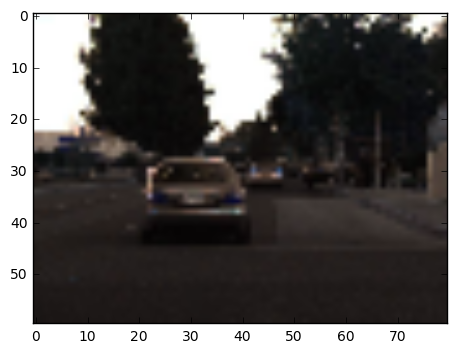

In [95]:
plt.imshow(X_train[100])

In [82]:
labels[690]

-0.027923307448400003

In [96]:
y_train[100]

'1477429517970458116.png'

In [106]:
csv_file = pd.read_csv("/Volumes/DANIEL/Challenge-2/Sample/3/interpolated.csv",
                           usecols=['filename', 'angle', 'frame_id'])

In [107]:
csv_file[csv_file['filename']== 'center/1477429660840318727.png']

,frame_id,filename,angle
1861,center_camera,center/1477429660840318727.png,-0.027923


In [108]:
csv_file['angle'].describe()

count    1991.000000
mean       -0.012089
std         0.054512
min        -0.176851
25%        -0.025003
50%        -0.001745
75%         0.013001
max         0.115192
Name: angle, dtype: float64

In [ ]:
25%        -0.015667
50%        -0.000211
75%         0.024435

In [111]:
data = pd.read_csv('/Users/daniel/Dropbox/udacity_challenge2/rawdata/driving_dataset/data.txt', delimiter= ' ')


In [118]:
data['radian'] = data['angle'] * 0.0174533
data['radian'].describe()

count    45406.000000
mean         0.030457
std          0.539600
min         -2.791306
25%         -0.095120
50%          0.017628
75%          0.154811
max          8.757717
Name: radian, dtype: float64